In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier


In [19]:
df = pd.read_csv("adult 3 (1).csv")  # Adjust path if needed
df.head(10)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


In [34]:
df.tail(3)

,age,educational-num,capital-gain,capital-loss,hours-per-week,income,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
48837,27,12,0,0,38,0,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
48838,40,9,0,0,40,1,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
48839,58,9,0,0,40,0,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False


In [33]:
df.shape

(28795, 95)

In [20]:
df.info()
df.describe()
df['income'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


income
<=50K    37155
>50K     11687
Name: count, dtype: int64

In [21]:
# Replace '?' with NaN and drop rows with NaN
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)

In [28]:
# Define a function to remove outliers using IQR method
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Columns to check for outliers
numeric_columns = ['age', 'hours-per-week', 'capital-gain', 'capital-loss']

# Apply the outlier removal function to each column
for col in numeric_columns:
    df = remove_outliers_iqr(df, col)

# Check updated shape
print("Shape after outlier removal:", df.shape)


Shape after outlier removal: (28795, 96)


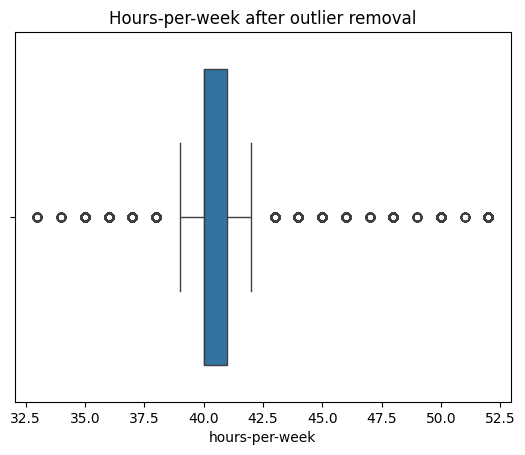

In [29]:
sns.boxplot(x=df['hours-per-week'])
plt.title("Hours-per-week after outlier removal")
plt.show()


In [22]:
# Use LabelEncoder for binary and one-hot encoding for others
label = LabelEncoder()
df['income'] = label.fit_transform(df['income'])  # <=50K=0, >50K=1

# Drop 'fnlwgt' (optional)
df.drop('fnlwgt', axis=1, inplace=True)

# Convert categorical columns using pd.get_dummies
categorical = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=categorical, drop_first=True)


In [30]:
from scipy import stats

# Select numeric columns
numeric_cols = ['age', 'hours-per-week', 'capital-gain', 'capital-loss']

# Z-score calculation
z_scores = np.abs(stats.zscore(df[numeric_cols]))

# Keep only rows where all Z-scores are below threshold (e.g., 3)
df = df[(z_scores < 3).all(axis=1)]

# Check updated shape
print("Shape after Z-score outlier removal:", df.shape)


Shape after Z-score outlier removal: (0, 96)


In [23]:
X = df.drop('income', axis=1)
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
plt.show()

In [25]:
model = RandomForestClassifier()
model.fit(X_train, y_train)


RandomForestClassifier()

In [26]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8452183526810393
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      6842
           1       0.71      0.61      0.66      2203

    accuracy                           0.85      9045
   macro avg       0.80      0.77      0.78      9045
weighted avg       0.84      0.85      0.84      9045



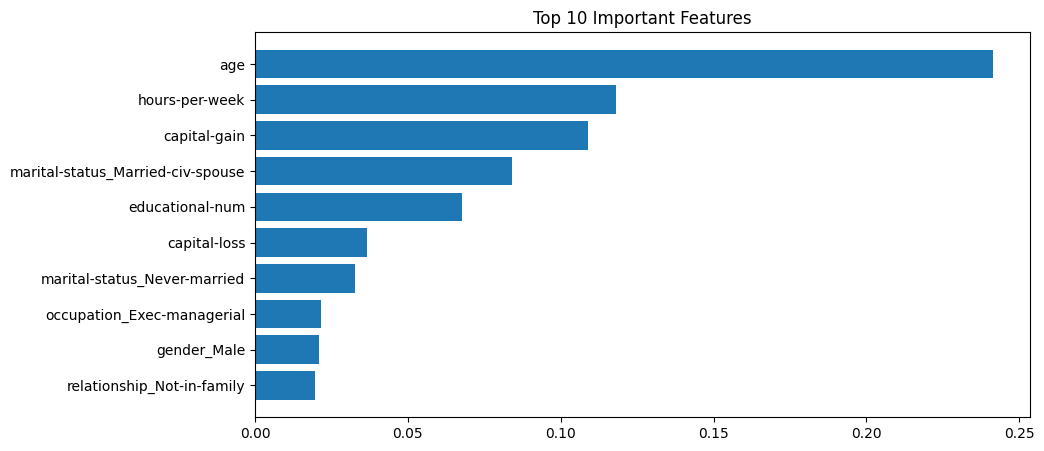

In [27]:
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # top 10 features
plt.figure(figsize=(10,5))
plt.title("Top 10 Important Features")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.show()
